# Build Simple Valuation Model and Evaluate on Test Data

In this notebook:
- Preliminaries (importing packages, setting options)
- Preprocess data ready for use by LightGBM.  Includes:
    - splitting into training, validation and testing samples
    - dropping columns which contain information not available at time or valuation (i.e. avoid target leakage)
    - convert columns which are categorical to Category data type (this is checked by LightGBM)
- Train GBM, using validation sample for early stopping
- Assess performance in training sample.  Overall not bad for quick and dirty: mean absolute error of ~ 10%
- Looking at the feature importances:
    - No surprise that total area (represented by TotalArea and SubTotal columns) is the most important predictor!
    - Interesting that OtherFloors, which represents the area of floors that are **not** ground, first or second floors, is important.  As we know from the visualisations this is picking-up tall buildings where are concentrated in cities and especially the Square Mile.
    - Offices, internal storage and car parking spaces are also important
    - Sadly, having a bar is not important (at least when predicting ratebale value for 2m properties!)
    
- Future work (!):
    - No hyperparameter tuning (well, I did some manually) but that is important
    - One observation - accuracy is poor for properties will small rateable values becuase the model never predicts rateable value below ~ 2,000

LightGBM documentation [here](https://lightgbm.readthedocs.io/en/latest/index.html)



## Preliminaries

In [209]:
import pandas as pd
import numpy as np
import re
import geopandas as gpd
import json
import plotly.express as px
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import gc

In [2]:
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [3]:
from tqdm.notebook import tqdm
import pickle

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [6]:
shapefilepath = 'GB_Postcodes/GB_Postcodes/PostalArea.shp'

In [114]:
mod = pickle.load(open('mod.p','rb'))

In [115]:
mod.rename(columns={'Store ':'Store_03'}, inplace=True)
mod = mod[mod['Adopted RV'] > 1]
mod = mod.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [116]:
# Check full any nulls
#mod.isna().sum()

In [117]:
mod.columns

Index(['BillingAuthorityCode', 'FirmsName', 'Town', 'PostalDistrict', 'County',
       'Postcode', 'SchemeReference', 'PrimaryDescriptionText', 'TotalArea',
       'SubTotal', 'TotalValue', 'AdoptedRV', 'SCATCodeOnly',
       'UnitofMeasurement', 'UnadjustedPrice', 'GroundFirstOrSecond',
       'OtherFloor', 'AllMainAreas', 'AreaUnderSupportedFloor', 'Bar',
       'Canteen', 'ChillStore', 'Classroom', 'ColdStore', 'ComputerRoom',
       'ExternalStorage', 'Garage', 'GolfCourse', 'GroundFloorSales', 'Hall',
       'HardSurfacedFencedLand_02', 'InternalStorage', 'Kitchen', 'Laboratory',
       'Lounge', 'MessStaffRoom', 'Nursery', 'Office_02', 'OtherDescription',
       'ParkingSpaceS', 'ProductionArea', 'ReceptionEntrance',
       'RemainingRetailZone', 'Restaurant', 'RetailArea', 'RetailZoneA',
       'RetailZoneB', 'RetailZoneC', 'RoughSurfacedFencedLand_02', 'Showroom',
       'SingleBedSpace', 'Store', 'Surgery', 'TotalFloorAreaDryLeisureClubs',
       'UnsurfacedFencedLand_02', 'Wa

In [118]:
# Create labels and features

In [119]:
y = mod['AdoptedRV']
X = mod.drop(['AdoptedRV','FirmsName','UnadjustedPrice','TotalValue'], axis=1)

In [120]:
# Convert object to cetegory for LGBM
X[X.select_dtypes(['object']).columns] = X[X.select_dtypes(['object']).columns].astype('category')

In [121]:
# Split data into training, validation and testing

In [122]:
len(X)

1966970

In [123]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=44)

In [124]:
X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.20, random_state=44)

In [125]:
print('The average Adopted RVs in the three datasets are: Train ' + str(int(np.mean(y))) + ' Validation ' + str(int(np.mean(y_valid))) + ' Test ' + str(int(np.mean(y_test))))

The average Adopted RVs in the three datasets are: Train 27966 Validation 27689 Test 27536


## Use Microsoft's LightGBM to Train an ensemble of regression trees
No hyperparameter tuning yet

In [126]:
train_data = lgb.Dataset(X, label=y, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False)
X = None
X_valid = None
mod = None
gc.collect()

363

In [127]:
# specify parameter config
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse', 'mae'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                train_data,
                num_boost_round=300,
                valid_sets=valid_data,early_stopping_rounds=10)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215630 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\paul_\Miniconda3\envs\voa-data-project\lib\site-packages\lightgbm\basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

C:\Users\paul_\Miniconda3\envs\voa-data-project\lib\site-packages\lightgbm\basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[1]	valid_0's l1: 31029.3	valid_0's rmse: 148751
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 27961.4	valid_0's rmse: 136586
[3]	valid_0's l1: 25200.3	valid_0's rmse: 125921
[4]	valid_0's l1: 22721.7	valid_0's rmse: 116403
[5]	valid_0's l1: 20486.9	valid_0's rmse: 108287
[6]	valid_0's l1: 18538.9	valid_0's rmse: 100998
[7]	valid_0's l1: 16773.6	valid_0's rmse: 94651.7
[8]	valid_0's l1: 15199.5	valid_0's rmse: 88938.6
[9]	valid_0's l1: 13789.7	valid_0's rmse: 84043.2
[10]	valid_0's l1: 12508.3	valid_0's rmse: 79915.5
[11]	valid_0's l1: 11381.6	valid_0's rmse: 75855.3
[12]	valid_0's l1: 10370.9	valid_0's rmse: 73067.5
[13]	valid_0's l1: 9459.79	valid_0's rmse: 70340.4
[14]	valid_0's l1: 8691	valid_0's rmse: 68137.1
[15]	valid_0's l1: 7978.62	valid_0's rmse: 66090.3
[16]	valid_0's l1: 7363.29	valid_0's rmse: 64413.6
[17]	valid_0's l1: 6822.42	valid_0's rmse: 62958.9
[18]	valid_0's l1: 6325.33	valid_0's rmse: 61715.9
[19]	valid_0's l1: 5909.62	valid_0's rm

In [128]:
print('Saving model...')
# save model to file
gbm.save_model('model.txt')

Saving model...


# Assess model performance on (unseen) training data

In [129]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', int(mean_squared_error(y_test, y_pred) ** 0.5))
print('The mae of prediction is:', int(mean_absolute_error(y_test, y_pred)))

Starting predicting...
The rmse of prediction is: 49844
The mae of prediction is: 2944


In [130]:
# Get feature importance

<AxesSubplot:ylabel='Feature'>

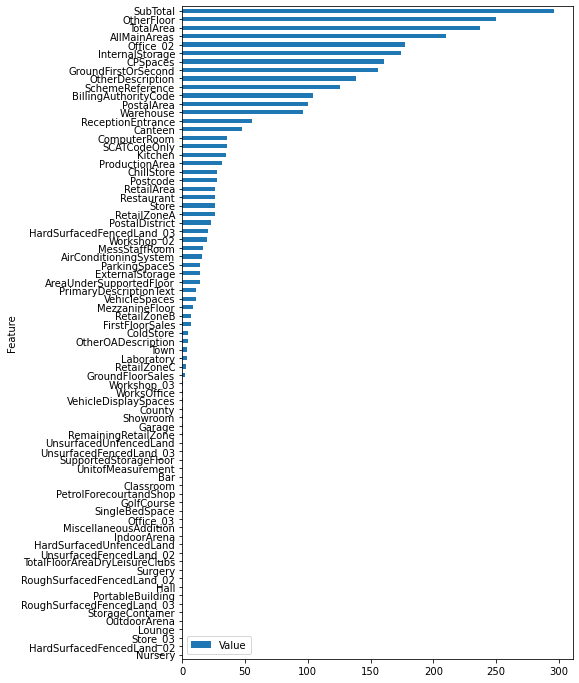

In [131]:
gbmimportance = pd.DataFrame({'Value':gbm.feature_importance(),'Feature':X_test.columns.tolist()}).sort_values(by="Value")
gbmimportance.plot.barh(x='Feature', figsize=(7,12))

In [133]:
# Profile predictions and accuracy
X_test['Predicted RV'] = y_pred
X_test['Adopted RV'] = y_test
X_test['Absolute error'] = abs(X_test['Predicted RV'] - X_test['Adopted RV'])
X_test['Absolute percent error'] = X_test['Absolute error'] / X_test['Adopted RV']

In [ ]:
# MAPE by adopted RV

In [159]:
X_test['Vintiles of Adopted RV'] = pd.qcut(X_test['Adopted RV'],20)

<AxesSubplot:xlabel='Vintiles of Adopted RV'>

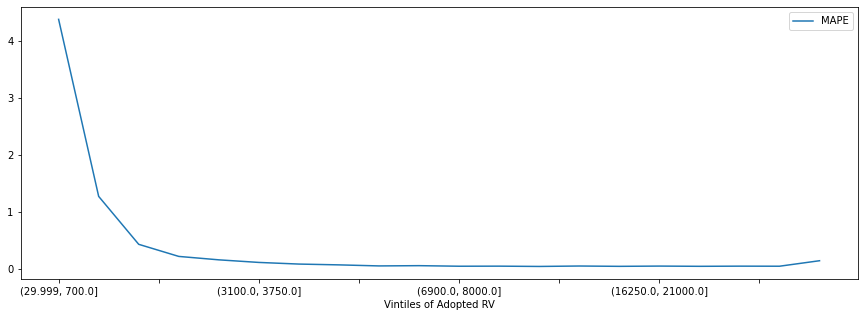

In [179]:
z = X_test[['Absolute error','Adopted RV','Vintiles of Adopted RV']].groupby('Vintiles of Adopted RV').sum()
z['MAPE'] = z['Absolute error']/z['Adopted RV']
z.plot(y='MAPE',figsize=(15,5))

In [ ]:
# So poor accuracy for properties with low rateable vlaues ~ < 2,000

(0.0, 20000.0)

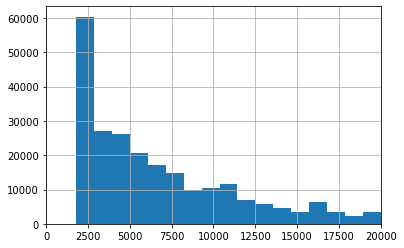

In [190]:
ax = X_test['Predicted RV'][X_test['Predicted RV']<20000].hist(bins=100)
ax.set_xlim((0,20000))

In [ ]:
# Interesting, so there are no predicted values below 2000

In [ ]:
# MAPE by Postal Area

In [203]:
X_pa = X_test[['PostalArea','Absolute error','Adopted RV']].reset_index().groupby('PostalArea').sum().reset_index()
X_pa = pa.merge(X_pa, right_on='PostalArea', left_on='PostArea', how='inner')
X_pa['MAPE'] = X_pa['Absolute error']/X_pa['Adopted RV']

In [206]:
def postalareaplot(metric):
    f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,7))
    f.suptitle('Total ' + metric + ' by Postal Area', fontsize=16)
    X_pa.plot(ax=ax1, column=metric, legend=True)
    ax1.set(title='England and Wales')
    ax1.tick_params(labelbottom=False, labelleft=False)
    X_pa[X_pa['Sprawl']=='London'].plot(ax=ax2,column=metric, legend=True)
    ax2.set(title='London')
    ax2.tick_params(labelbottom=False, labelleft=False)

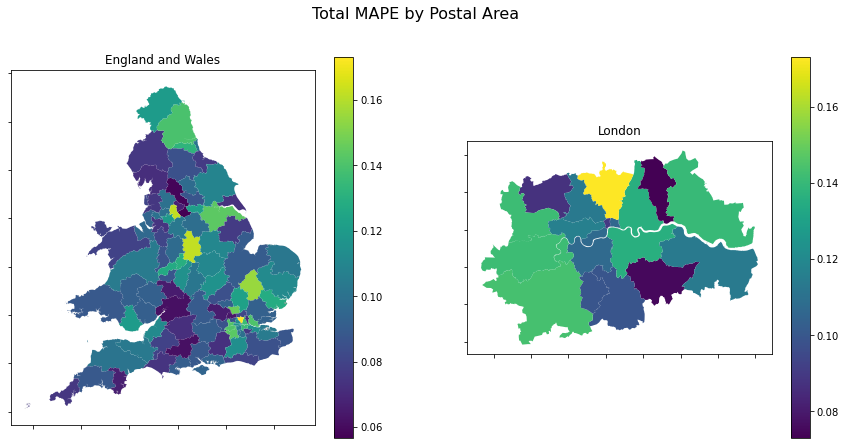

In [207]:
postalareaplot('MAPE')